In [1]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime
from sklearn.ensemble import IsolationForest
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import warnings 
warnings.filterwarnings("ignore")

/Users/subikshaa/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/subikshaa/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/subikshaa/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/subikshaa/anaconda3/lib/python3.7/site-packages/tensorflow/pyth

In [2]:
# Read pre-processed data
top_page_df = pd.read_csv('Preprocessed_data/final_data.csv')
top_page_df = top_page_df.set_index('Date')

In [6]:
# Time-series of page with maximum views
top_pages = df_reshaped.groupby('Page')['Views'].sum().reset_index()
top_pages_list = top_pages.nlargest(5,'Views')['Page'].tolist()

top_page_df = df_reshaped[df_reshaped.Page == top_pages_list[0]]
top_page_df = top_page_df[['Views']]
top_page_df['Views'] = top_page_df['Views'].div(1000000).round(2)
top_page_df.head()

,Views
Date,
2015-07-01,20.38
2015-07-02,20.75
2015-07-03,19.57
2015-07-04,20.44
2015-07-05,20.77


## Anomaly detection

In [7]:
# Detecting anomalies in the data, removing anomalies and filling missing values with rolling mean
isolation_forest_model = IsolationForest(contamination=0.08)
isolation_forest_model.fit(top_page_df)
top_page_df['anomaly'] = isolation_forest_model.predict(top_page_df)

top_page_df['new_views'] = top_page_df.apply(lambda row: row.Views if row.anomaly == 1 else None, axis='columns')
top_page_df = top_page_df.assign(rolling_mean=top_page_df.new_views.fillna(top_page_df.new_views.rolling(30,min_periods=1).mean()))
top_page_df = top_page_df.drop(columns=['Views','anomaly','new_views']).rename(columns={'rolling_mean':'Views'})

In [3]:
# Convert dataset into suitable form to train the model
train = top_page_df[:'2016-09']
test = top_page_df['2016-10':]

def transform_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7

X_train, y_train = transform_dataset(train, train.Views, time_steps)
X_test, y_test = transform_dataset(test, test.Views, time_steps)

In [4]:
# Building the model
n_features=1
model = keras.Sequential()
model.add(keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_steps, n_features)))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [5]:
# Training the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    verbose=1,
    shuffle=False
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
421/421 [==============================] - 0s 568us/sample - loss: 301.7494
Epoch 2/20
421/421 [==============================] - 0s 47us/sample - loss: 86.0850
Epoch 3/20
421/421 [==============================] - 0s 45us/sample - loss: 8.9935
Epoch 4/20
421/421 [==============================] - 0s 39us/sample - loss: 5.1175
Epoch 5/20
421/421 [==============================] - 0s 42us/sample - loss: 2.7050
Epoch 6/20
421/421 [==============================] - 0s 43us/sample - loss: 2.4182
Epoch 7/20
421/421 [==============================] - 0s 39us/sample - loss: 2.3232
Epoch 8/20
421/421 [==============================] - 0s 37us/sample - loss: 2.2971
Epoch 9/20
421/421 [==============================] - 0s 40us/sample - loss: 2.2671
Epoch 10/20
421/421 [==============================] - 0s 37us/sample - loss: 2.2649
Epoch 11/20
421/421 [==============================] - 0s 40us/sample - loss: 2.2528
Epoch 12/20
421/421 [=

In [6]:
# Forecasting using test data. Test data is used for forecasting to validate the results and calculate RMSE
y_pred = model.predict(X_test)

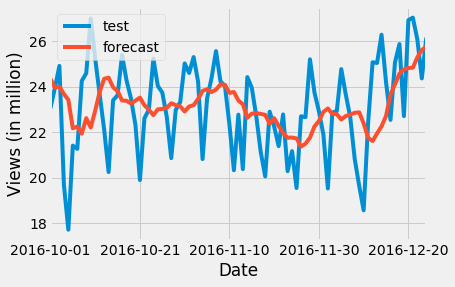

In [7]:
fig,ax=plt.subplots()
pd.DataFrame({'Date':test.index[:y_test.shape[0]],'Views':y_test}).plot('Date',ax=ax)
pd.DataFrame({'Date':test.index[:y_pred.shape[0]],'Views':y_pred.flatten()}).plot('Date',ax=ax)
plt.legend(['test', 'forecast'], loc='upper left')
plt.ylabel('Views (in million)')
plt.show()

In [8]:
print('RMSE:'+str(np.sqrt(np.mean(np.square(y_pred.flatten() - y_test)))))

RMSE:2.0027657329476893
